# TOC:
* [FDR corrected maps](#fdr-bullet)
* [TFCE corrected positive SV maps](#tfce_pos-bullet)
* [TFCE corrected negative SV maps](#tfce_neg-bullet)


In [1]:
# load modules
from scipy.stats import stats
import scipy.io as spio
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
# from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
from nilearn.input_data import NiftiMasker
import nilearn.plotting as plotting
from nilearn.image import mean_img
from nilearn import image
# import pickle
import pandas as pd
import seaborn as sns 

import nipype.pipeline.engine as pe
from nipype.interfaces import spm
from nipype.interfaces import fsl


%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


200106-20:53:35,280 nipype.utils INFO:
	 Running nipype version 1.2.3 (latest: 1.4.0)


Autosaving every 5 seconds


In [2]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/home/rj299/project/MATLAB/toolbox/spm12/') # set default SPM12 path in my computer.

fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

base_root = '/home/rj299/scratch60/mdm_analysis/'
data_root = '/home/rj299/scratch60/mdm_analysis/data_rename'
out_root = '/home/rj299/scratch60/mdm_analysis/output'

# Subjects included in analysis
sub_num = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 
           2596, 2597, 2598, 2599, 2600, 2624, 2650, 2651, 2652, 2653, 
           2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 
           2664, 2665, 2666]

sub_num.sort()
print('All subjects included in analysis:', sub_num)
print(len(sub_num), 'subjects')

All subjects included in analysis: [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 2596, 2597, 2598, 2599, 2600, 2624, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666]
33 subjects


In [3]:
# load anatomical
anat_mean = nib.load(os.path.join(out_root, 'imaging', 'all_sub_average.nii.gz'))

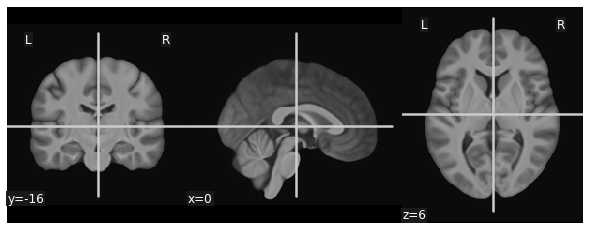

In [4]:
fig = plt.figure(figsize = (8,3))
plotting.plot_anat(anat_mean, black_bg = True, figure = fig)

### FDR thresholded <a class = "anchor" id = "fdr-bullet"></a>

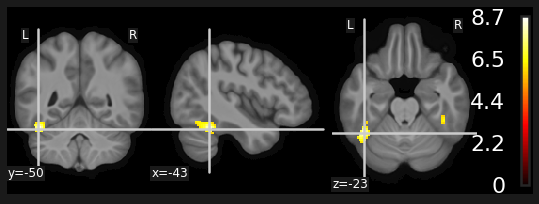

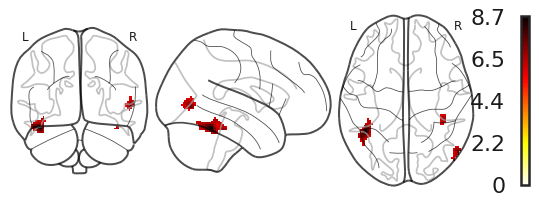

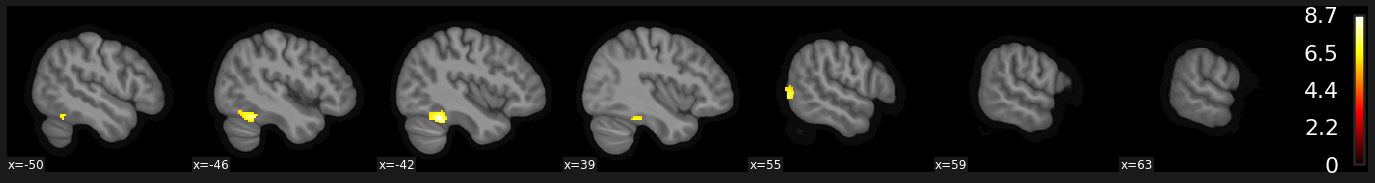

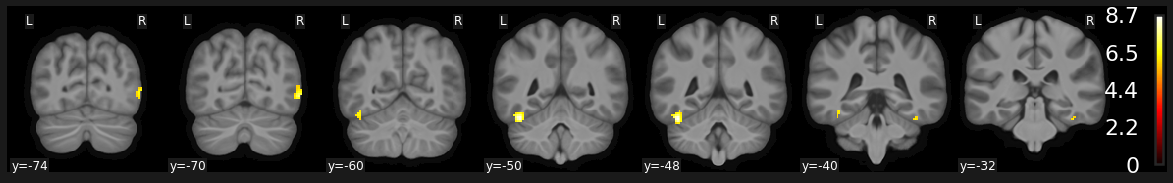

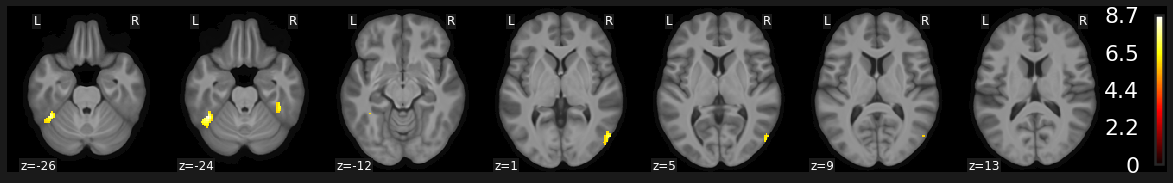

In [9]:
# second-level output: FDR corrected

con_id = '0009'
plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001_thr.nii' %con_id,
                       anat_mean)

plotting.plot_glass_brain('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001_thr.nii' %con_id,
                       colorbar = True)

plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001_thr.nii' %con_id,
                       anat_mean,
                      display_mode = 'x')

plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001_thr.nii' %con_id,
                       anat_mean,
                      display_mode = 'y')

plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001_thr.nii' %con_id,
                       anat_mean,
                      display_mode = 'z')

## TFCE

Positive SV maps <a class = "anchor" id = "tfce_pos-bullet"></a>

In [ ]:
con_id = '0013'

con_all = {}

for i in sub_num:
    con_image = glob.glob('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_' + str(i) + '/con_' + con_id + '.nii')
    con_all[str(i)] = list(con_image)
# con_all
# len(con_all)

# smooth, fwhm = none
smooth_con_all = []

for k, v in con_all.items():
    smooth_con = image.smooth_img(v[0],None) #  If fwhm is None, no filtering is performed (useful when just removal of non-finite values is needed).
    print(v)
    smooth_con_all.append(smooth_con)
    
#     plotting.plot_glass_brain(smooth_con, colorbar = True)

# concatenate
con_concat = image.concat_imgs(smooth_con_all, auto_resample = True)
con_concat.to_filename(os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'mon_sv_glm_con%s_all_sub.nii.gz' %con_id))


cluster_thr = fsl.Randomise(in_file = os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'mon_sv_glm_con%s_all_sub.nii.gz' %con_id),
                            mask = '/home/rj299/scratch60/mdm_analysis/output/imaging/wb_mask_group.nii.gz',
                            base_name = os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'con%s' %con_id),
                            one_sample_group_mean = True,
                            tfce = True,
                            vox_p_values = True,
                            num_perm = 5000)
cluster_thr.run()

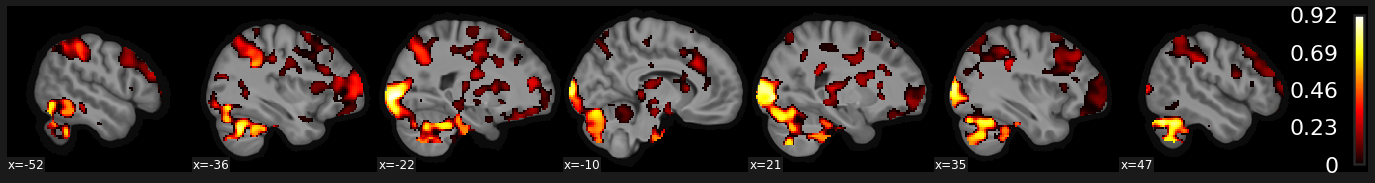

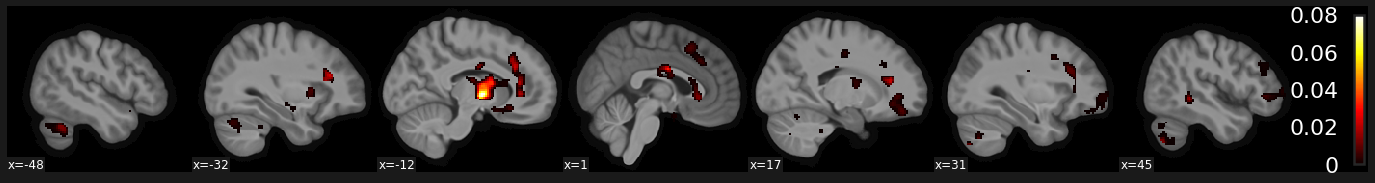

In [13]:
# p maps
con_ids = ['0012', '0013']
# con_id = '0013'

for con_id in con_ids:

    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_tfce_corrp_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                           display_mode = 'x',
                           colorbar=True)
    
#     plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/sv_map_correction/con%s_tfce_corrp_tstat1.nii.gz' %con_id,
#                           bg_img = anat_mean,
#                            display_mode = 'x',
#                            threshold = 0.8, 
#                            colorbar=True)

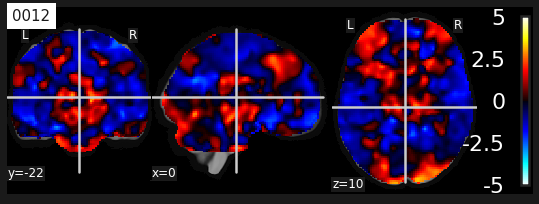

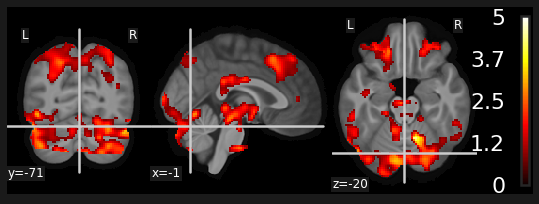

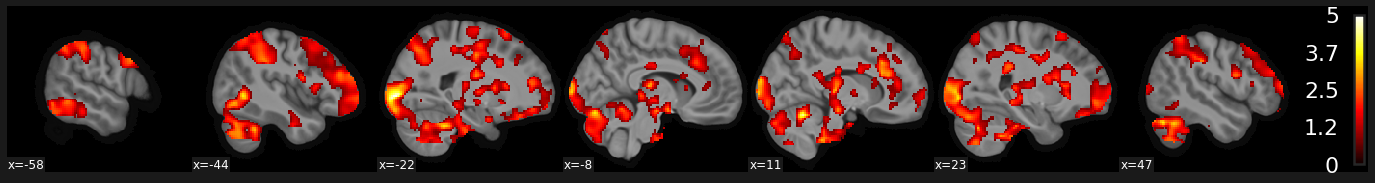

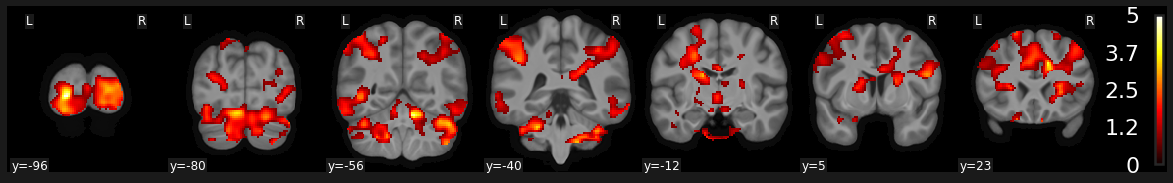

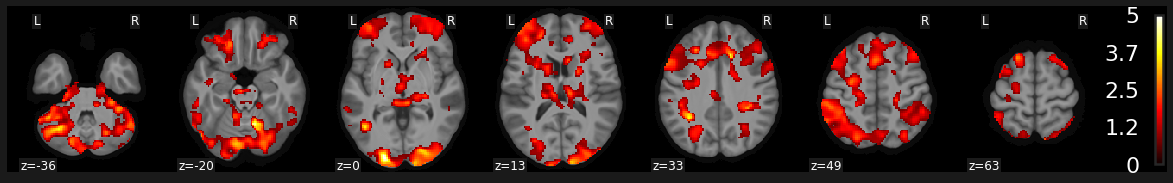

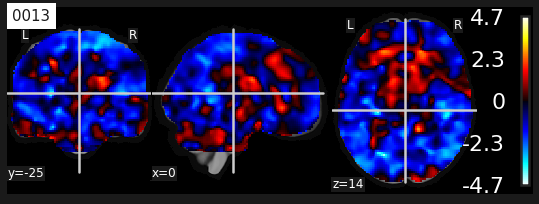

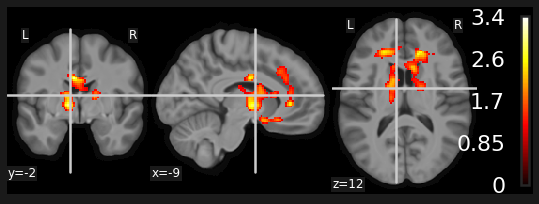

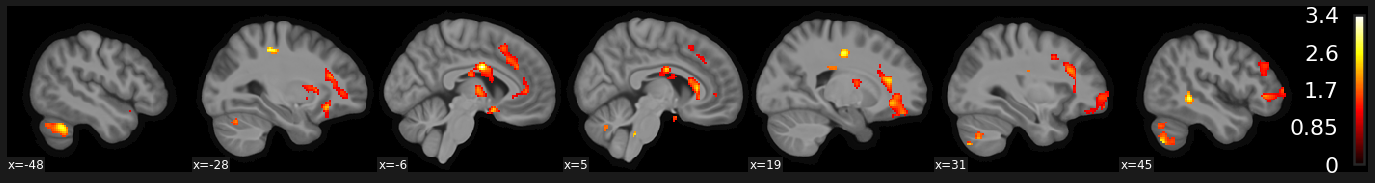

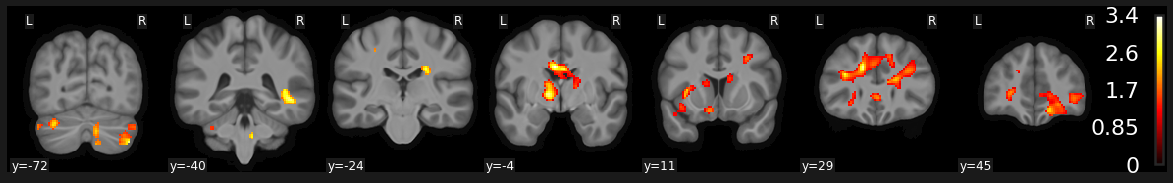

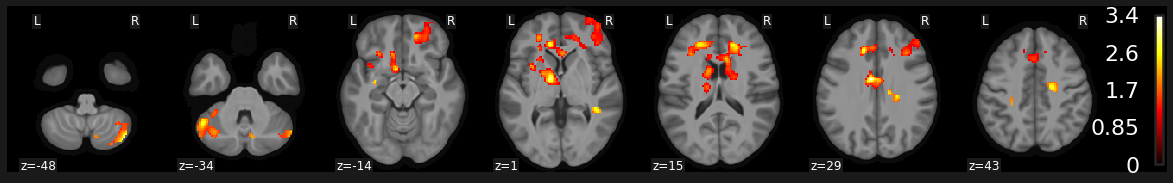

In [14]:
# visualize thresholded t values
con_ids = ['0012', '0013']


for con_id in con_ids:
    
    t_plot = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_tstat1.nii.gz' %con_id)
    p = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_tfce_corrp_tstat1.nii.gz' %con_id)

    # thr = 0.95
    t_plot_data = t_plot.get_data()
    p_data = p.get_data()

    # threshold raw t map by p values
    p_mask = p_data == 0
    t_plot_data[p_mask] = 0    
    
    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                          title = con_id)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="x", 
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="y",
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="z",
                           colorbar=True)

Flipped, Negative SV maps <a class = "anchor" id = "tfce_neg-bullet"></a>

In [ ]:
# flipped
con_ids = ['0012', '0013']

for con_id in con_ids:
#     con_id = '0010'

    con_all = {}

    for i in sub_num:
        con_image = glob.glob('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_' + str(i) + '/con_' + con_id + '.nii')
        con_all[str(i)] = list(con_image)
    # con_all
    # len(con_all)

    # smooth, fwhm = none
    smooth_con_all = []

    for k, v in con_all.items():
        smooth_con = image.smooth_img(v[0],None) #  If fwhm is None, no filtering is performed (useful when just removal of non-finite values is needed).
        smooth_con_all.append(smooth_con)

    #     plotting.plot_glass_brain(smooth_con, colorbar = True)

    # flip sign for negative SV maps
    smooth_con_flip_all = []

    for smooth_img in smooth_con_all:
        smooth_img_flip = image.math_img("-img", img=smooth_img)
        smooth_con_flip_all.append(smooth_img_flip)

    # concatenate    
    con_concat_flip = image.concat_imgs(smooth_con_flip_all, auto_resample = True)
    con_concat_flip.to_filename(os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'mon_sv_glm_con%s_flip_all_sub.nii.gz' %con_id))


    cluster_thr = fsl.Randomise(in_file = os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'mon_sv_glm_con%s_flip_all_sub.nii.gz' %con_id),
                                mask = '/home/rj299/scratch60/mdm_analysis/output/imaging/wb_mask_group.nii.gz',
                                base_name = os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'con%s_flip' %con_id),
                                one_sample_group_mean = True,
                                tfce = True,
                                vox_p_values = True,
                                num_perm = 5000)
    cluster_thr.run()

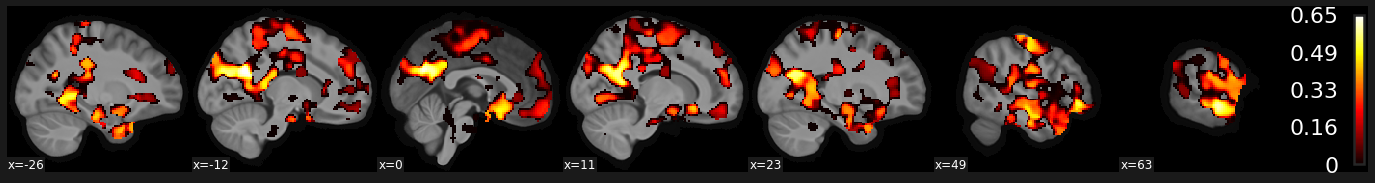

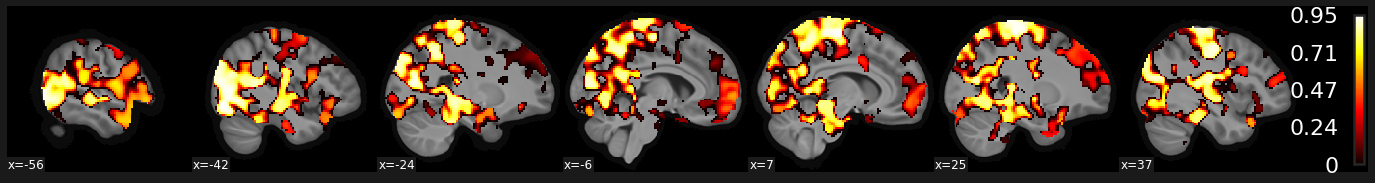

In [4]:
# p maps
con_ids = ['0012', '0013']
# con_id = '0013'

for con_id in con_ids:

    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_flip_tfce_corrp_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                           display_mode = 'x',
#                            threshold = 8,
                           colorbar=True)
    

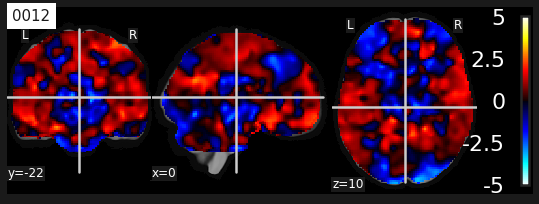

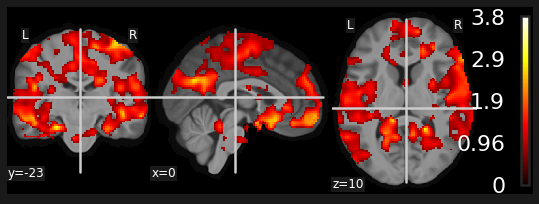

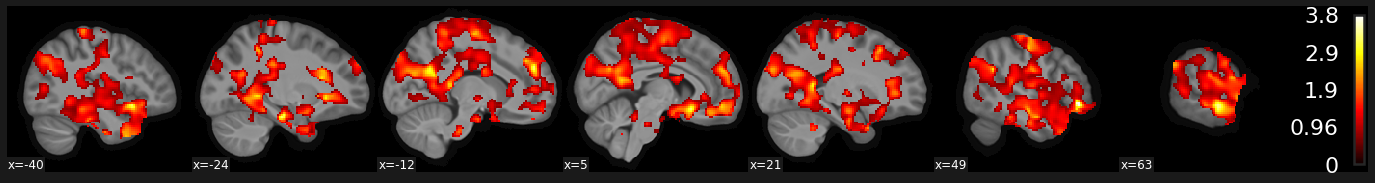

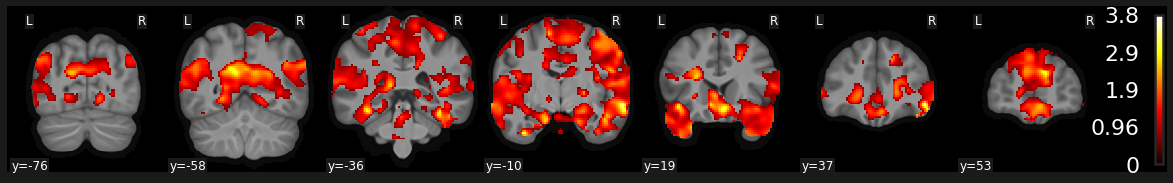

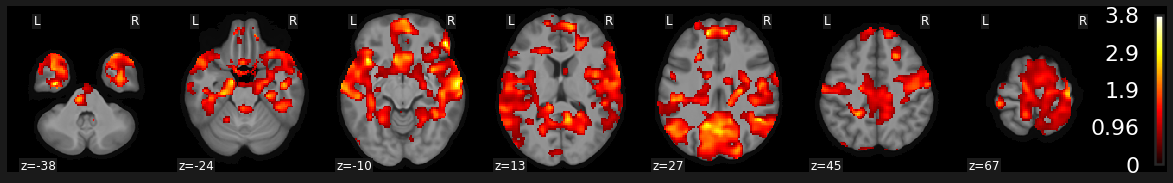

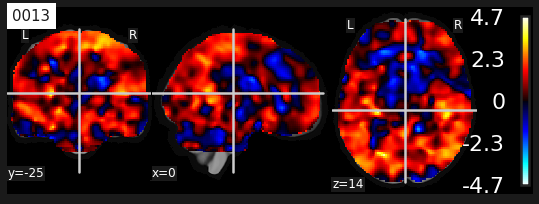

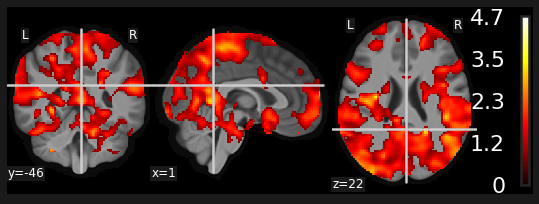

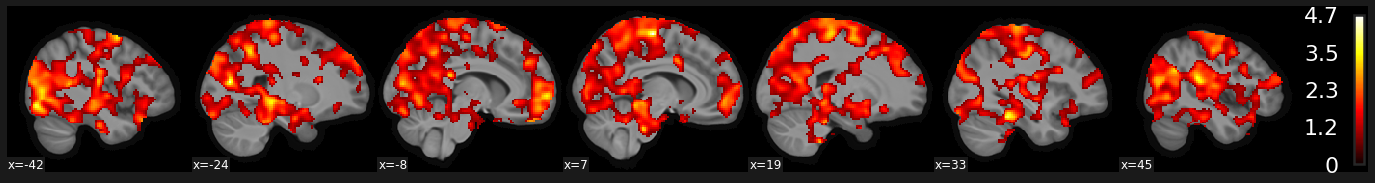

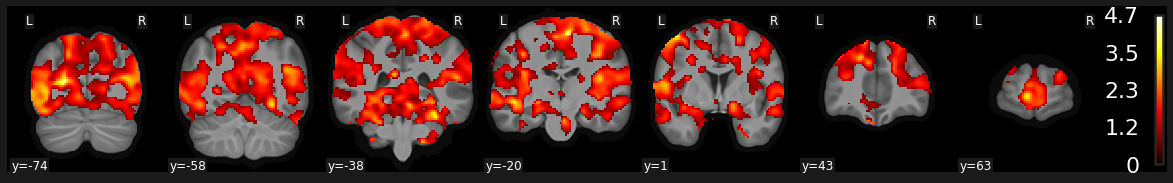

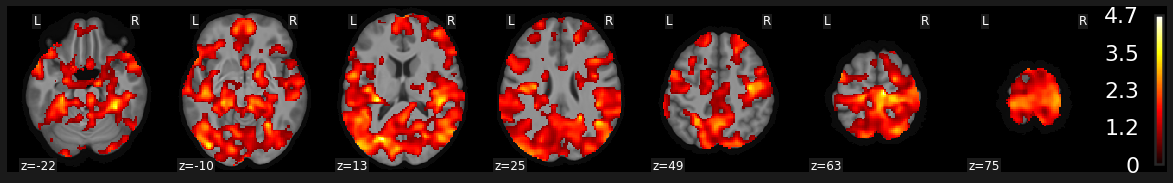

In [9]:
# visualize thresholded t values
con_ids = ['0012', '0013']


for con_id in con_ids:
    
    t_plot = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_flip_tstat1.nii.gz' %con_id)
    p = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_flip_tfce_corrp_tstat1.nii.gz' %con_id)

#     thr = 0.95
    t_plot_data = t_plot.get_data()
    p_data = p.get_data()

    # threshold raw t map by p values
#     p_mask = p_data < thr
    p_mask = p_data == 0
    t_plot_data[p_mask] = 0    
    
    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_flip_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                          title = con_id)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="x", 
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="y",
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="z",
                           colorbar=True)